<a href="https://colab.research.google.com/github/neimarcos/Mestrado/blob/main/prototipo_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Testes iniciais com grafico simples, feito na mão no exemplo

{0: 1, 1: 2, 2: 5, 3: 2, 4: 1, 5: 2, 6: 1, 7: 1, 8: 2, 9: 1}
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']


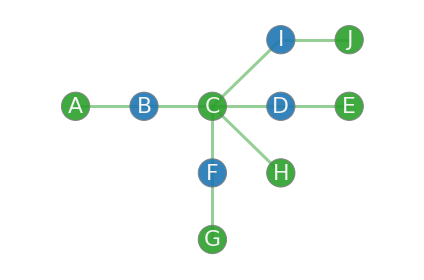

In [142]:
from logging import Handler
from numpy.lib.function_base import append
#!sudo pulptest
import matplotlib.pyplot as plt
import networkx as nx
from networkx.readwrite import json_graph
from pprint import pprint
import matplotlib.patches as mpatches

G = nx.Graph()
pos = {0: (0,0), 1:(1,0) , 2: (2,0), 3: (3, 0), 4: (4, 0), 5: (2, -1), 6: (2, -2), 7: (3, -1), 8: (3, 1), 9: (4, 1)}
node_labels = { 0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F", 6: "G", 7: "H", 8: "I", 9: "J"}

G.add_nodes_from(node_labels)
G.add_edges_from([(0, 1),(1, 2),(2, 3),(3, 4),(2, 5),(2, 7),(5, 6),(2, 8),(8, 9)])


betweenness_centrality = nx.betweenness_centrality(G)
#pprint('betweenness_centrality')


all_values = betweenness_centrality.values()
max_value = max(all_values)

# If a node is a probe station, then the color is green else it is  blue
nodes_color = []
for x in betweenness_centrality:
  if betweenness_centrality[x]==0 or betweenness_centrality[x]==max_value:
    nodes_color.append("tab:green")    
  else:
    nodes_color.append("tab:blue")



# nodes
options = {"edgecolors": "tab:gray", "node_size": 800, "alpha": 0.9}
nx.draw_networkx_nodes(G, pos, nodelist=[ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9], node_color=nodes_color, **options)

# edges
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=G.edges,
    width=3,
    alpha=0.5,
    edge_color="tab:green",
)


nx.draw_networkx_labels(G, pos, node_labels, font_size=22, font_color="whitesmoke")
nx.write_graphml(G,"saida")

# Creates a list of all the supply nodes
Routes= list(node_labels.values())

# Creates a dictionary for the number of probes in each host
Probes = {}
for nodes in G:
  Probes[nodes]=len(G.edges(nodes))



pprint(Probes)



pprint(Routes)
plt.tight_layout()
plt.axis("off")
plt.show()

# Save graph





